In [ ]:
import pandas as pd
import numpy as np 


In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet


     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 184kB 7.5MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640345 sha256=cd01660f964621b34a766bda985e2a544c639c7ead6ea6cf9c00e452251b1e94
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/xxiang27/sikkaAIHackathon/main/data_file.csv')
df.head()

,id,month,year,visits,no_of_appts,production
0,34,3,2014,1,960,76.55
1,34,4,2014,488,1089,106333.80
2,34,5,2014,831,993,192230.40
3,34,6,2014,753,884,163515.12
4,34,7,2014,721,797,160185.90


In [ ]:
df['day'] = 15
dates = pd.to_datetime(df[['month', 'year','day']].copy())
dates.head()

0   2014-03-15
1   2014-04-15
2   2014-05-15
3   2014-06-15
4   2014-07-15
dtype: datetime64[ns]

In [ ]:
df_final = pd.concat([dates, df],axis=1)
# df_final = df_final.drop(columns = ['month', 'year', 'day'])
df_final.columns.values[0] = 'date'
df_final.head()

,date,id,month,year,visits,no_of_appts,production,day
0,2014-03-15,34,3,2014,1,960,76.55,15
1,2014-04-15,34,4,2014,488,1089,106333.80,15
2,2014-05-15,34,5,2014,831,993,192230.40,15
3,2014-06-15,34,6,2014,753,884,163515.12,15
4,2014-07-15,34,7,2014,721,797,160185.90,15


In [ ]:
# separate dataframe into separate dataframes for each practice 

import math 

def separate(df):
  '''takes a dataframe returns a list of dataframes, 
  one for each unique value under the id column'''
  lst = []
  grouped = df.groupby(df.id)
  for i in range(1, 285):
    lst.append(grouped.get_group(i))
  return lst 

def train_test_split(lst, percent):
  '''takes a list of dataframes and returns the time series train and test split based on the percent'''
  test_set = []
  for df in lst:
    add_test = math.floor(len(df) * percent)
    df_add = df.tail(add_test).copy()
    test_set.append(df_add)
    df.drop(df.tail(add_test).index, inplace = True)
  df_train = pd.concat(lst, ignore_index=True)
  df_test = pd.concat(test_set, ignore_index = True)
  return df_train, df_test
  



In [ ]:
train_lst = separate(df_final)
df_train, df_test = train_test_split(train_lst, 0.2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_final = train_lst[0]
only_prod = df_final.drop(columns = ['id', 'visits', 'no_of_appts', 'month', 'year'])
only_prod = only_prod.rename(columns={0: "ds", "production": "y"})
only_prod = only_prod[['date', 'y']]
only_prod.head()

,date,y
10524,2016-10-15,1854.70
10525,2016-11-15,11352.45
10526,2016-12-15,17854.65
10527,2017-01-15,11869.50
10528,2017-02-15,15596.90


In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(7)

In [ ]:
only_prod = only_prod.drop(columns = ['date'])

In [ ]:
dataset = only_prod.values
dataset = dataset.astype('float32')

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

26 14


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
testY


array([[0.9815799 , 0.77105612, 0.80989778, 0.82963032, 0.73337126,
        0.77146953, 0.80247176, 0.80638963, 0.74625283, 0.80928618,
        0.66501862, 0.51689845]])

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
24/24 - 2s - loss: 0.2776
Epoch 2/100
24/24 - 0s - loss: 0.2384
Epoch 3/100
24/24 - 0s - loss: 0.2007
Epoch 4/100
24/24 - 0s - loss: 0.1685
Epoch 5/100
24/24 - 0s - loss: 0.1401
Epoch 6/100
24/24 - 0s - loss: 0.1145
Epoch 7/100
24/24 - 0s - loss: 0.0952
Epoch 8/100
24/24 - 0s - loss: 0.0769
Epoch 9/100
24/24 - 0s - loss: 0.0632
Epoch 10/100
24/24 - 0s - loss: 0.0532
Epoch 11/100
24/24 - 0s - loss: 0.0460
Epoch 12/100
24/24 - 0s - loss: 0.0404
Epoch 13/100
24/24 - 0s - loss: 0.0370
Epoch 14/100
24/24 - 0s - loss: 0.0349
Epoch 15/100
24/24 - 0s - loss: 0.0334
Epoch 16/100
24/24 - 0s - loss: 0.0324
Epoch 17/100
24/24 - 0s - loss: 0.0319
Epoch 18/100
24/24 - 0s - loss: 0.0316
Epoch 19/100
24/24 - 0s - loss: 0.0313
Epoch 20/100
24/24 - 0s - loss: 0.0311
Epoch 21/100
24/24 - 0s - loss: 0.0309
Epoch 22/100
24/24 - 0s - loss: 0.0308
Epoch 23/100
24/24 - 0s - loss: 0.0307
Epoch 24/100
24/24 - 0s - loss: 0.0304
Epoch 25/100
24/24 - 0s - loss: 0.0304
Epoch 26/100
24/24 - 0s - loss: 0.

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.16 RMSE
Test Score: 0.20 RMSE


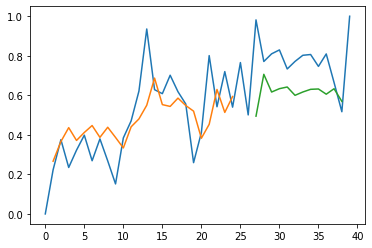

In [ ]:
import matplotlib.pyplot as plt
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()